In [1]:
import os
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]
scores = {"ner": {}, "pos": {}, "copa": {}, "qa": {}}
tasks = scores.keys()
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1"}
inf = math.inf
for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

# we rename all keys
renames = {
    "reconstructed_featural": "Approximation method",
    "baseline_en": "English language adapter",
    "baseline_closest_featural": "MAD-X",
    "finetune": "Fine-tuning",
    "no_train_gain": "No Train but Gain",
    "baseline_avg_adapter": "Parameter averaging",
}
scores_renamed = {}
for task in scores:
    scores_renamed[task] = {}
    for lang, keys in scores[task].items():
        scores_renamed[task][lang] = {}
        for key, score in scores[task][lang].items():
            if key in renames.keys():
                scores_renamed[task][lang][renames[key]] = score
old_scores = scores
scores = scores_renamed


langs = set()
for task in tasks:
    for lang_name in scores[task]:
        if "Approximation method" not in scores[task][lang_name].keys():
            continue
        langs.add(lang_name)
# we remove all languages from score that are not in langs
for task_name in scores:
    for lang_name in list(scores[task_name].keys()):
        if lang_name not in langs:
            del scores[task_name][lang_name]
# we make a subset consisting of only the languages for which an adapter exists
with_adapter = {}
no_adapter = {}
for task_name in scores:
    with_adapter[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            with_adapter[task_name][lang_name] = scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = scores[task_name][lang_name]
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                task_name = file.split("_")[0]
                token_overlap[task_name] = data
        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)


print("total languages:", len(langs))
for task in tasks:
    print(f"task: {task}, {len(set(scores[task]).intersection(langs))} languages")
    print(
        f"{len(set(with_adapter[task]).intersection(langs))} have a trained language adapter, {len(set(no_adapter[task]).intersection(langs))} not"
    )
    print(
        f"{len(set(xlm_included[task]).intersection(langs))} are in the xlm included languages, {len(set(xlm_not_included[task]).intersection(langs))} not"
    )
    # we make a list of all languages

total languages: 157
task: ner, 134 languages
29 have a trained language adapter, 105 not
85 are in the xlm included languages, 49 not
task: pos, 80 languages
19 have a trained language adapter, 61 not
57 are in the xlm included languages, 23 not
task: copa, 11 languages
11 have a trained language adapter, 0 not
11 are in the xlm included languages, 0 not
task: qa, 12 languages
11 have a trained language adapter, 1 not
12 are in the xlm included languages, 0 not


In [9]:
# we make a copy of no_adapter in which we change the name of "MAD-X" to "Closest Adapter"
no_adapter_closest = {}
for task in no_adapter:
    no_adapter_closest[task] = {}
    for language in no_adapter[task]:
        no_adapter_closest[task][language] = {}
        for key, score in no_adapter[task][language].items():
            if key == "MAD-X":
                no_adapter_closest[task][language]["Closest adapter"] = score
            else:
                no_adapter_closest[task][language][key] = score
scores_closest = {}
for task in scores:
    scores_closest[task] = {}
    for language in scores[task]:
        scores_closest[task][language] = {}
        for key, score in scores[task][language].items():
            if key == "MAD-X" and language not in existing_adapters:
                scores_closest[task][language]["Closest adapter"] = score
            else:
                scores_closest[task][language][key] = score

In [13]:
no_adapter

{'ner': {'ace': {'Fine-tuning': 0.20911528150134046,
   'Approximation method': 0.36423841059602646,
   'English language adapter': 0.3344262295081967,
   'Parameter averaging': 0.27272727272727276,
   'MAD-X': 0.3958333333333333,
   'No Train but Gain': 0.3879598662207358},
  'af': {'Fine-tuning': 0.6343397377249161,
   'Approximation method': 0.7266584766584767,
   'English language adapter': 0.7029702970297029,
   'Parameter averaging': 0.6690163409163731,
   'MAD-X': 0.6592661116250385,
   'No Train but Gain': 0.7144607843137256},
  'als': {'Fine-tuning': 0.35804701627486435,
   'Approximation method': 0.6063157894736841,
   'English language adapter': 0.5872340425531913,
   'Parameter averaging': 0.5277777777777778,
   'MAD-X': 0.5678496868475991,
   'No Train but Gain': 0.5865580448065173},
  'am': {'Fine-tuning': 0.3352601156069364,
   'Approximation method': 0.36781609195402293,
   'English language adapter': 0.25274725274725274,
   'Parameter averaging': 0.32888888888888884,
 

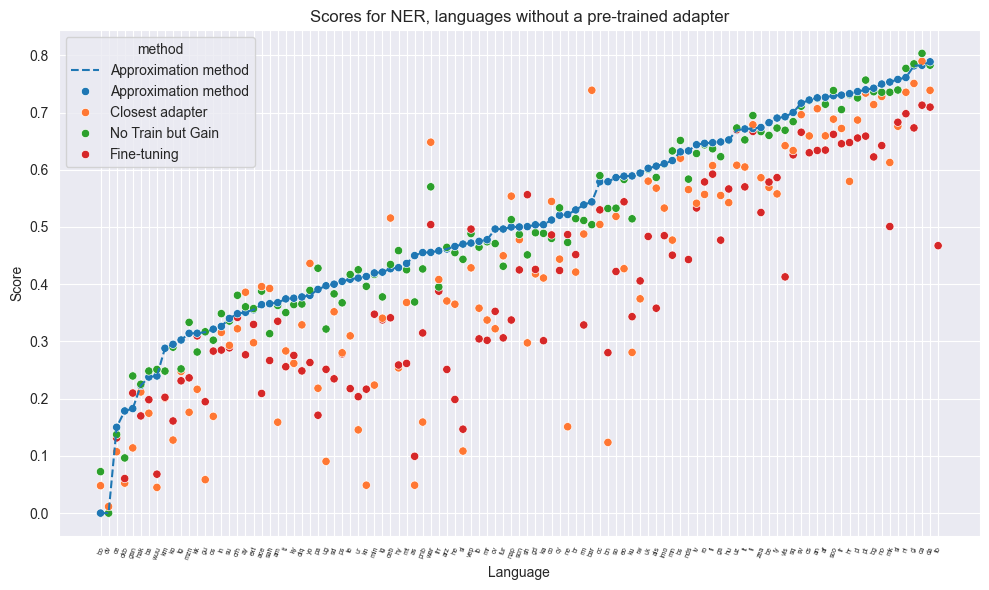

In [15]:
# we make a lineplot of the scores for different tasks
# the scores should be sorted from lowest to highest for reconstructed_featural, with a line connecting the points
# we define a global palette and hue‐order so different runs have the same colors
METHODS = [
    "Approximation method",
    "MAD-X",
    "Closest adapter",
    "No Train but Gain",
    "Fine-tuning",
]
PALETTE = {
    "Approximation method": "#1f77b4",  # blue
    "MAD-X": "#ffdf0e",  # orange
    "Closest adapter": "#ff7733",
    "No Train but Gain": "#2ca02c",  # green
    "Fine-tuning": "#d62728",  # red
}


def custom_plot(
    task_name,
    column,
    save=False,
    dataframe=scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
):
    data = []
    for lang_name in dataframe[task_name]:
        if column in dataframe[task_name][lang_name]:
            data.append([task_name, lang_name, dataframe[task_name][lang_name][column], column])
        for baseline in baselines:
            if baseline in dataframe[task_name][lang_name]:
                data.append([task_name, lang_name, dataframe[task_name][lang_name][baseline], baseline])
    df = pd.DataFrame(data, columns=["task", "lang_name", "score", "method"])
    df = df.sort_values(by=["score"])
    plt.figure(figsize=(10, 6))
    main = df[df.method == column]
    plt.plot(main.lang_name, main.score, linestyle="--", color=PALETTE[column], label=column)
    if plot_type == "line":
        sns.lineplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
            marker="o",
        )
    elif plot_type == "scatter":
        sns.scatterplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
        )
        # we add a line only for reconstructed_featural

    plt.title(f"Scores for {task_name.upper()}, languages without a pre-trained adapter")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=70, size=5)
    plt.tight_layout()
    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot(
    "ner",
    "Approximation method",
    dataframe=no_adapter_closest,
    save="no_adapter",
    plot_type="scatter",
    baselines=["Fine-tuning", "Closest adapter", "No Train but Gain"],
)

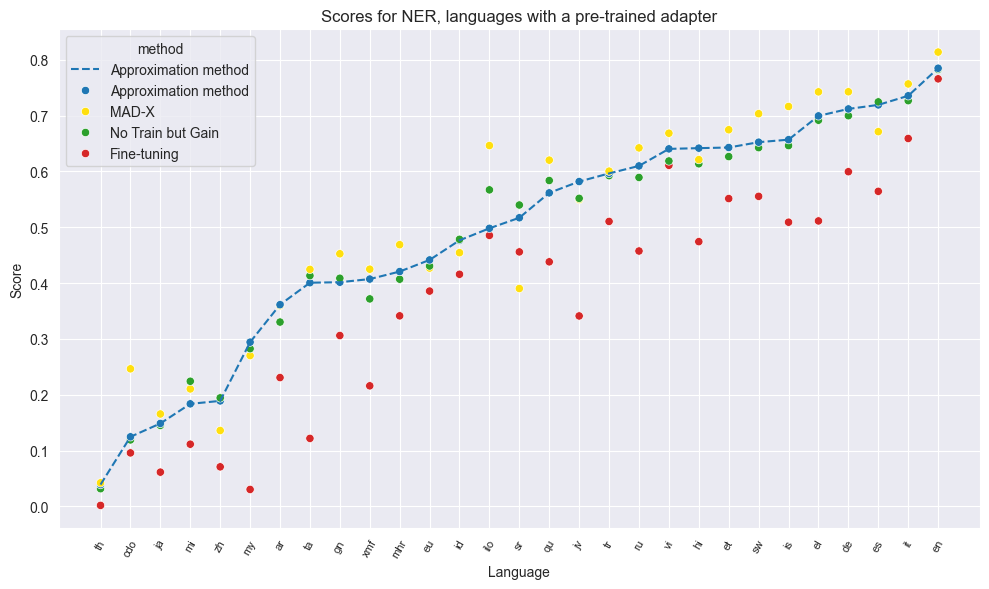

In [16]:
# we make a lineplot of the scores for different tasks
# the scores should be sorted from lowest to highest for reconstructed_featural, with a line connecting the points
# we define a global palette and hue‐order so different runs have the same colors
METHODS = [
    "Approximation method",
    "MAD-X",
    "Closest adapter",
    "No Train but Gain",
    "Fine-tuning",
]
PALETTE = {
    "Approximation method": "#1f77b4",  # blue
    "MAD-X": "#ffdf0e",  # orange
    "Closest adapter": "#ff7733",
    "No Train but Gain": "#2ca02c",  # green
    "Fine-tuning": "#d62728",  # red
}


def custom_plot(
    task_name,
    column,
    save=False,
    dataframe=scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
):
    data = []
    for lang_name in dataframe[task_name]:
        if column in dataframe[task_name][lang_name]:
            data.append([task_name, lang_name, dataframe[task_name][lang_name][column], column])
        for baseline in baselines:
            if baseline in dataframe[task_name][lang_name]:
                data.append([task_name, lang_name, dataframe[task_name][lang_name][baseline], baseline])
    df = pd.DataFrame(data, columns=["task", "lang_name", "score", "method"])
    df = df.sort_values(by=["score"])
    plt.figure(figsize=(10, 6))
    main = df[df.method == column]
    plt.plot(main.lang_name, main.score, linestyle="--", color=PALETTE[column], label=column)
    if plot_type == "line":
        sns.lineplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
            marker="o",
        )
    elif plot_type == "scatter":
        sns.scatterplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
        )
        # we add a line only for reconstructed_featural

    plt.title(f"Scores for {task_name.upper()}, languages with a pre-trained adapter")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=60, size=8)
    plt.tight_layout()
    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot(
    "ner",
    "Approximation method",
    dataframe=with_adapter,
    save="with_adapter",
    plot_type="scatter",
    baselines=["Fine-tuning", "MAD-X", "No Train but Gain"],
)

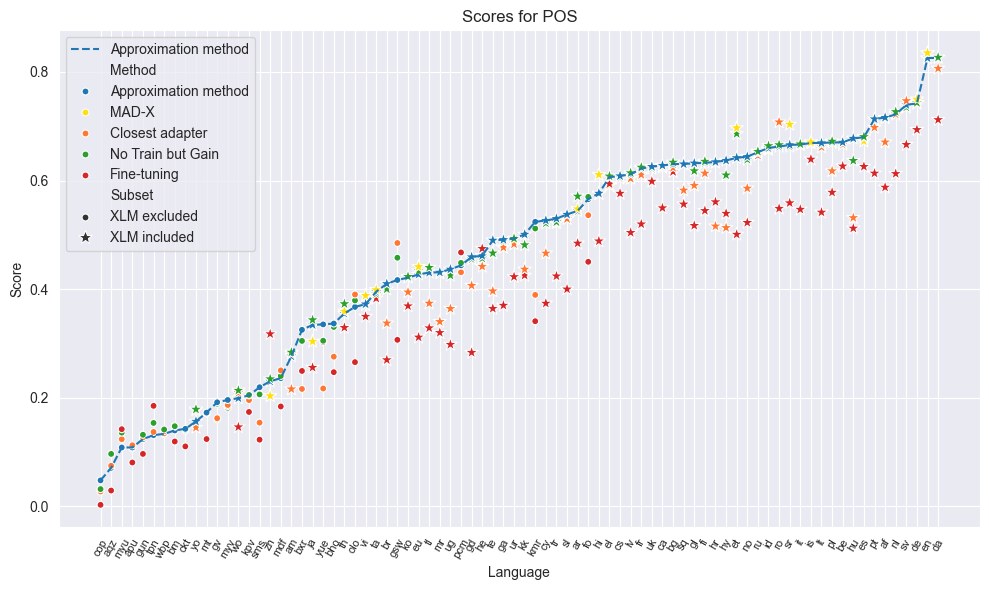

In [21]:
def custom_plot_with_figure(
    task_name,
    column,
    dataframe,
    subset_scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
    save=False,
):
    # 1) collect all methods + record which subset each lang comes from
    data = []
    for lang in dataframe[task_name]:
        # figure out which “subset” this is
        subset_label = "XLM included" if lang in subset_scores.get(task_name, {}) else "XLM excluded"
        # main metric
        if column in dataframe[task_name][lang]:
            data.append([lang, dataframe[task_name][lang][column], column, subset_label])
        # baselines
        for baseline in baselines:
            if baseline in dataframe[task_name][lang]:
                data.append([lang, dataframe[task_name][lang][baseline], baseline, subset_label])
    df = pd.DataFrame(data, columns=["lang", "score", "Method", "Subset"])
    df = df.sort_values("score")

    plt.figure(figsize=(10, 6))
    # dashed line for the main metric
    main = df[df.Method == column]
    plt.plot(main.lang, main.score, linestyle="--", color=PALETTE[column], label=column)

    if plot_type == "line":
        sns.lineplot(
            x="lang",
            y="score",
            hue="Method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            style="Subset",
            data=df,
            markers=True,
            dashes=False,
        )
    else:  # scatter
        sns.scatterplot(
            x="lang",
            y="score",
            hue="Method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            style="Subset",
            data=df,
            markers={"XLM excluded": ".", "XLM included": "*"},
            s=100,
        )

    plt.title(f"Scores for {task_name.upper()}")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=60, fontsize=8)
    plt.tight_layout()

    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot_with_figure(
    "pos",
    "Approximation method",
    dataframe=scores_closest,
    subset_scores=xlm_included,
    save="xlm",
    plot_type="scatter",
    baselines=["Fine-tuning", "MAD-X", "Closest adapter", "No Train but Gain"],
)

Overall score (Results 

In [5]:
# we present the results for each baseline in a table
# we calculate the mean for each baseline
table_scores = {
    "Reconstruction method": "reconstructed_featural",
    "No Train but Gain": "no_train_gain",
    "English language adapter": "baseline_en",
    "MAD-X": "baseline_closest_featural",
    "Parameter averaging": "baseline_avg_adapter",
    "Fine-tuning": "finetune",
}
baselines = [
    "Approximation method",
    "No Train but Gain",
    "English language adapter",
    "MAD-X",
    "Parameter averaging",
    "Fine-tuning",
]
means = {}
for baseline in baselines:
    all_scores = []
    for task in tasks:
        for lang_name in scores[task]:
            if baseline in scores[task][lang_name]:
                all_scores.append(scores[task][lang_name][baseline])
    means[baseline] = round(np.mean(all_scores), 3)
# we make a dataframe with the means
means_df = pd.DataFrame(means, index=["Score"]).T
lat = means_df.to_latex()
print(lat)

\begin{tabular}{lr}
\toprule
 & Score \\
\midrule
Approximation method & 0.504000 \\
No Train but Gain & 0.499000 \\
English language adapter & 0.478000 \\
MAD-X & 0.458000 \\
Parameter averaging & 0.437000 \\
Fine-tuning & 0.410000 \\
\bottomrule
\end{tabular}


# Overview of scores per task and method

In [6]:
metrics = ["Approximation method", "MAD-X", "No Train but Gain", "Fine-tuning"]
tasks = ["ner", "pos", "copa", "qa"]
subsets = {
    "Overall": scores,
    "No adapter": no_adapter,
    "With adapter": with_adapter,
    "XLM included": xlm_included,
    "XLM excluded": xlm_not_included,
}
# Compute averages
records = []
for task in tasks:
    row = {"task": task}
    for subset_name, subset in subsets.items():
        langs = list(subset[task].keys())
        for metric in metrics:
            values = [subset[task][lang].get(metric, np.nan) for lang in langs]
            row[(subset_name, metric)] = np.nanmean(values) if values else np.nan
    records.append(row)

# Build DataFrame
index = [r["task"] for r in records]
columns = pd.MultiIndex.from_product([list(subsets.keys()), metrics], names=["Subset", "Metric"])
df_avg = pd.DataFrame(
    [[r[(subset, metric)] for subset in subsets for metric in metrics] for r in records], index=index, columns=columns
)

# Display
df_avg.round(4)

Subset              Overall                                        \
Metric Approximation method   MAD-X No Train but Gain Fine-tuning   
ner                  0.5013  0.4335            0.4931      0.3922   
pos                  0.4679  0.4461            0.4686      0.4003   
copa                 0.5498  0.5645            0.5493      0.5553   
qa                   0.7271  0.7211            0.7253      0.5337   

Subset           No adapter                                        \
Metric Approximation method   MAD-X No Train but Gain Fine-tuning   
ner                  0.5052  0.4136            0.4957      0.3969   
pos                  0.4404  0.4102            0.4393      0.3671   
copa                    NaN     NaN               NaN         NaN   
qa                   0.7891  0.7660            0.7812      0.6239   

Subset         With adapter                                        \
Metric Approximation method   MAD-X No Train but Gain Fine-tuning   
ner                  0.4875  0.5049            0.4839      0.3751   
pos                  0.5564  0.5614            0.5624      0.5069   
copa                 0.5498  0.5645            0.5493      0.5553   
qa                   0.7215  0.7170            0.7202      0.5255   

Subset         XLM included                                        \
Metric Approximation method   MAD-X No Train but Gain Fine-tuning   
ner                  0.5518  0.4689            0.5416      0.4311   
pos                  0.5595  0.5369            0.5596      0.4831   
copa                 0.5498  0.5645            0.5493      0.5553   
qa                   0.7271  0.7211            0.7253      0.5337   

Subset         XLM excluded                                        
Metric Approximation method   MAD-X No Train but Gain Fine-tuning  
ner                  0.4120  0.3707            0.4073      0.3246  
pos                  0.2409  0.2211            0.2429      0.1950  
copa                    NaN     NaN               NaN         NaN  
qa                      NaN     NaN               NaN         NaN

In [7]:
df_table = df_avg.T
# 1) transpose so that Subset×Metric → rows, Tasks → columns
df_table.index.names = ["Subset", "Metric"]


# 3) compute min/median/max for each Task‐column (for the gradient macro)
col_stats = {}

for task in df_table.columns:
    vals = df_table[task].dropna().astype(float)
    mn, md, mx = vals.min(), float(np.median(vals)), vals.max()
    col_stats[task] = (mn, md, mx)

# 4) build a formatter for each Task ==> Per-column color coding
formatters = {}
for task, (mn, md, mx) in col_stats.items():
    formatters[task] = (
        lambda mn, md, mx: lambda x: (f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}" if not pd.isna(x) else "")
    )(mn, md, mx)

# 5) export to LaTeX, using multirow on the Subset level
latex = df_table.to_latex(escape=True, formatters=formatters, multirow=True)
print(latex)

\begin{tabular}{llrrrr}
\toprule
 &  & ner & pos & copa & qa \\
Subset & Metric &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Overall} & Approximation method & \tgrad[0.325][0.451][0.552]{0.501} & \tgrad[0.195][0.457][0.562]{0.468} & \tgrad[0.549][0.553][0.565]{0.550} & \tgrad[0.525][0.721][0.789]{0.727} \\
 & MAD-X & \tgrad[0.325][0.451][0.552]{0.433} & \tgrad[0.195][0.457][0.562]{0.446} & \tgrad[0.549][0.553][0.565]{0.565} & \tgrad[0.525][0.721][0.789]{0.721} \\
 & No Train but Gain & \tgrad[0.325][0.451][0.552]{0.493} & \tgrad[0.195][0.457][0.562]{0.469} & \tgrad[0.549][0.553][0.565]{0.549} & \tgrad[0.525][0.721][0.789]{0.725} \\
 & Fine-tuning & \tgrad[0.325][0.451][0.552]{0.392} & \tgrad[0.195][0.457][0.562]{0.400} & \tgrad[0.549][0.553][0.565]{0.555} & \tgrad[0.525][0.721][0.789]{0.534} \\
\cline{1-6}
\multirow[t]{4}{*}{No adapter} & Approximation method & \tgrad[0.325][0.451][0.552]{0.505} & \tgrad[0.195][0.457][0.562]{0.440} & NaN & \tgrad[0.525][0.721][0.789]{0.789} \\
 & MAD-X &

In [8]:
import numpy as np
import pandas as pd

# 1) transpose so that Subset×Metric → rows, Tasks → columns
df_table = df_avg.T
df_table.index.names = ["Subset", "Metric"]

# 2) compute global min/median/max over every numeric cell
all_vals = pd.to_numeric(df_table.values.ravel(), errors="coerce")
mn, md, mx = np.nanmin(all_vals), float(np.nanmedian(all_vals)), np.nanmax(all_vals)


# 3) single formatter using the global [mn, md, mx]
def global_fmt(x, mn=mn, md=md, mx=mx):
    return f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}" if not pd.isna(x) else ""


# 4) apply the same formatter to every Task‐column
formatters = {task: global_fmt for task in df_table.columns}

# 5) export to LaTeX, allowing the \tgrad macro through
latex = df_table.to_latex(escape=False, formatters=formatters, multirow=True, na_rep="")

print(latex)

\begin{tabular}{llrrrr}
\toprule
 &  & ner & pos & copa & qa \\
Subset & Metric &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Overall} & Approximation method & \tgrad[0.195][0.534][0.789]{0.501} & \tgrad[0.195][0.534][0.789]{0.468} & \tgrad[0.195][0.534][0.789]{0.550} & \tgrad[0.195][0.534][0.789]{0.727} \\
 & MAD-X & \tgrad[0.195][0.534][0.789]{0.433} & \tgrad[0.195][0.534][0.789]{0.446} & \tgrad[0.195][0.534][0.789]{0.565} & \tgrad[0.195][0.534][0.789]{0.721} \\
 & No Train but Gain & \tgrad[0.195][0.534][0.789]{0.493} & \tgrad[0.195][0.534][0.789]{0.469} & \tgrad[0.195][0.534][0.789]{0.549} & \tgrad[0.195][0.534][0.789]{0.725} \\
 & Fine-tuning & \tgrad[0.195][0.534][0.789]{0.392} & \tgrad[0.195][0.534][0.789]{0.400} & \tgrad[0.195][0.534][0.789]{0.555} & \tgrad[0.195][0.534][0.789]{0.534} \\
\cline{1-6}
\multirow[t]{4}{*}{No adapter} & Approximation method & \tgrad[0.195][0.534][0.789]{0.505} & \tgrad[0.195][0.534][0.789]{0.440} &  & \tgrad[0.195][0.534][0.789]{0.789} \\
 & MAD-X & \t

In [9]:
import numpy as np
import pandas as pd

# 1) transpose so that Subset×Metric → rows, Tasks → columns
df_table = df_avg.T.copy()
df_table.index.names = ["Subset", "Metric"]

# 2) compute global [min, median, max] for the gradient
all_vals = pd.to_numeric(df_table.values.ravel(), errors="coerce")
mn, md, mx = np.nanmin(all_vals), float(np.nanmedian(all_vals)), np.nanmax(all_vals)

# 3) compute, per‐subset and per‐task, the max value
max_per_subset = df_table.groupby(level=0).max()

# 4) stringify every cell, applying both the gradient macro and bold on the max
df_str = df_table.copy().astype(object)

for (subset, metric), row in df_table.iterrows():
    for task in df_table.columns:
        x = row[task]
        if pd.isna(x):
            cell = ""
        else:
            # gradient
            grad = f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}"
            # bold if it's the subset‐max
            if x == max_per_subset.loc[subset, task]:
                cell = f"\\textbf{{{grad}}}"
            else:
                cell = grad
        df_str.at[(subset, metric), task] = cell

# 5) export to LaTeX (no additional formatters needed)
latex = df_str.to_latex(
    escape=False,  # let \tgrad and \textbf pass through
    multirow=True,
)

print(latex)

\begin{tabular}{llllll}
\toprule
 &  & ner & pos & copa & qa \\
Subset & Metric &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Overall} & Approximation method & \textbf{\tgrad[0.195][0.534][0.789]{0.501}} & \tgrad[0.195][0.534][0.789]{0.468} & \tgrad[0.195][0.534][0.789]{0.550} & \textbf{\tgrad[0.195][0.534][0.789]{0.727}} \\
 & MAD-X & \tgrad[0.195][0.534][0.789]{0.433} & \tgrad[0.195][0.534][0.789]{0.446} & \textbf{\tgrad[0.195][0.534][0.789]{0.565}} & \tgrad[0.195][0.534][0.789]{0.721} \\
 & No Train but Gain & \tgrad[0.195][0.534][0.789]{0.493} & \textbf{\tgrad[0.195][0.534][0.789]{0.469}} & \tgrad[0.195][0.534][0.789]{0.549} & \tgrad[0.195][0.534][0.789]{0.725} \\
 & Fine-tuning & \tgrad[0.195][0.534][0.789]{0.392} & \tgrad[0.195][0.534][0.789]{0.400} & \tgrad[0.195][0.534][0.789]{0.555} & \tgrad[0.195][0.534][0.789]{0.534} \\
\cline{1-6}
\multirow[t]{4}{*}{No adapter} & Approximation method & \textbf{\tgrad[0.195][0.534][0.789]{0.505}} & \textbf{\tgrad[0.195][0.534][0.789]{0.440}} & 

# Scores on a map


In [10]:
# we print the highest 3 key-value pairs in a combination
def get_highest(task, data):
    result = (-inf, None)
    for type, value in data[task].items():
        # value = value*100
        if "reconstructed" in type:
            if value > result[0]:
                result = (value, type)
    return result

Preparation

In [11]:
# we make a subset consisting of only the languages for which an adapter exists
with_adapter = {}
no_adapter = {}
for task_name in old_scores:
    with_adapter[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in old_scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            with_adapter[task_name][lang_name] = old_scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = old_scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in old_scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in old_scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = old_scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = old_scores[task_name][lang_name]

In [12]:
no_adapter

{'ner': {}, 'pos': {}, 'copa': {}, 'qa': {}}

In [13]:
subsets = {
    "Overall": old_scores,
    "No adapter": no_adapter,
    "With adapter": with_adapter,
    "XLM included": xlm_included,
    "XLM excluded": xlm_not_included,
}
baselines = old_scores["ner"]["ace"].keys()
tasks = old_scores.keys()
subset_mean_scores = {subset: {} for subset in subsets.keys()}
for subset_name, subset in subsets.items():
    subset_means = {task: {} for task in tasks}

    for task in tasks:
        for baseline in baselines:
            all_scores = []
            for lang_name in subset[task]:
                if baseline in subset[task][lang_name]:
                    all_scores.append(subset[task][lang_name][baseline])
            subset_means[task][baseline] = round(np.mean(all_scores), 3)
    subset_mean_scores[subset_name] = subset_means

C:\Users\stefa\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stefa\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
rename_dict = {
    "reconstructed_featural_limit": "Featural distance with limit",
    "reconstructed_featural_threshold": "Featural distance with threshold",
    "reconstructed_morphological_threshold": "Morphological distance with threshold",
    "reconstructed_featural_eu": "Featural distance",
    "reconstructed_featural": "Featural distance",
    "reconstructed_morphological_distVar": "Morphological distance",
    "reconstructed_syntactic_limit": "Syntactic distance with limit",
    "reconstructed_syntactic_threshold": "Syntactic distance with threshold",
    None: None,
}
scores_for_plot = {subset: {} for subset in subsets.keys()}
for subset_name, subset in subsets.items():
    for task in tasks:
        highest = get_highest(task, subset_mean_scores[subset_name])
        print(f"Highest score for {task} in {subset_name}: {highest[0]} ({highest[1]})")
        scores_for_plot[subset_name][task] = {rename_dict[highest[1]]: highest[0]}
        # we add some other baselines
        scores_for_plot[subset_name][task]["Fine-tuning"] = subset_mean_scores[subset_name][task]["finetune"]
        scores_for_plot[subset_name][task]["No Train but Gain"] = subset_mean_scores[subset_name][task]["no_train_gain"]
        scores_for_plot[subset_name][task]["MAD-X"] = subset_mean_scores[subset_name][task]["baseline_closest_featural"]

Highest score for ner in Overall: 0.513 (reconstructed_featural_limit)
Highest score for pos in Overall: 0.468 (reconstructed_featural)
Highest score for copa in Overall: 0.559 (reconstructed_featural_limit)
Highest score for qa in Overall: 0.729 (reconstructed_morphological_threshold)
Highest score for ner in No adapter: -inf (None)
Highest score for pos in No adapter: -inf (None)
Highest score for copa in No adapter: -inf (None)
Highest score for qa in No adapter: -inf (None)
Highest score for ner in With adapter: -inf (None)
Highest score for pos in With adapter: -inf (None)
Highest score for copa in With adapter: -inf (None)
Highest score for qa in With adapter: -inf (None)
Highest score for ner in XLM included: 0.562 (reconstructed_featural_limit)
Highest score for pos in XLM included: 0.562 (reconstructed_featural_threshold)
Highest score for copa in XLM included: 0.559 (reconstructed_featural_limit)
Highest score for qa in XLM included: 0.729 (reconstructed_morphological_thresho

In [20]:
rows = []
for subset_name, task_dict in scores_for_plot.items():
    methods = set().union(*(mappings.keys() for mappings in task_dict.values()))
    for method in methods:
        row = {"SUBSET": subset_name, "METHOD": method}
        for task in ["ner", "pos", "copa", "qa"]:
            row[task.upper()] = task_dict.get(task, {}).get(method, None)
        rows.append(row)

df = pd.DataFrame(rows)
# we map any -inf to Nan
df.replace(-np.inf, np.nan, inplace=True)
# we make a latex table
# latex = df.to_latex(index=False, float_format="%.3f", escape=False, na_rep="")

In [21]:
import numpy as np
import pandas as pd

# assume df is your DataFrame with columns TASK, METHOD, NER, POS, COPA, QA

# 1) Compute per-column min/median/max
metrics = ["NER", "POS", "COPA", "QA"]
col_stats = {}
for col in metrics:
    vals = df[col].dropna().astype(float)
    mn, md, mx = vals.min(), float(np.median(vals)), vals.max()
    col_stats[col] = (mn, md, mx)

# 2) Build formatters wrapping each value in \tgrad[min][med][max]{val}
formatters = {}
for col, (mn, md, mx) in col_stats.items():
    formatters[col] = (
        lambda mn, md, mx: lambda x: (f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}" if pd.notna(x) else "")
    )(mn, md, mx)

# 3) Determine fixed method ordering, dropping any missing entries
baselines = ["Fine-tuning", "MAD-X", "No Train but Gain"]
all_methods = [m for m in df["METHOD"].unique() if isinstance(m, str)]
others = sorted(m for m in all_methods if m not in baselines)
method_order = baselines + others


# 4) Re-order each TASK block according to method_order
def reorder_group(g):
    # set index so we can loc into method_order, but allow missing methods to become NaN rows
    tmp = g.set_index("METHOD")
    # reindex, filling missing combinations with empty rows if any
    re = tmp.reindex(method_order)
    # reset index back to columns, dropping fully-missing rows
    return re.reset_index().dropna(how="all", subset=metrics)


df_ordered = df.groupby("SUBSET", sort=False, group_keys=False).apply(reorder_group)

# 5) Set TASK+METHOD as MultiIndex for the table
df_idx = df_ordered.set_index(["SUBSET", "METHOD"])

# 6) Export to LaTeX with multirow and gradient formatters
latex = df_idx.to_latex(
    escape=False,  # allow \tgrad[…]{…}
    formatters=formatters,
    multirow=True,  # collapse TASK cells
    float_format="%.3f",  # fallback (won't affect our formatted columns)
    na_rep="",
)

# 2) Split into lines and rebuild, inserting a \cmidrule after each "No Train but Gain" line:
lines = latex.splitlines()
out = []
# total number of columns in the final table:
#  two index levels + one METHOD + len(metrics)
for L in lines:
    out.append(L)
    if "No Train but Gain" in L:
        # this draws a thin line spanning columns 1 through total_cols
        out.append(r"\cmidrule(lr){2-6}")

new_latex = "\n".join(out)

print(new_latex)

C:\Users\stefa\AppData\Local\Temp\ipykernel_21000\354404830.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reorder_group)


In [23]:
import numpy as np
import pandas as pd

# … your rows/DataFrame construction and -inf→NaN mapping …

metrics = ["NER", "POS", "COPA", "QA"]

# 1) Compute global min/median/max for gradients
col_stats = {
    col: (df[col].dropna().min(), float(np.median(df[col].dropna())), df[col].dropna().max()) for col in metrics
}

# 2) Compute per‐subset maxima
#    we’ll align these back to each row via groupby().transform()
subset_max = df.groupby("SUBSET")[metrics].transform("max")

# 3) Overwrite each metric cell with its final LaTeX string
for col in metrics:
    mn, md, mx = col_stats[col]

    def wrap(val, maxval):
        if pd.isna(val):
            return ""
        body = f"{val:.3f}"
        if np.isclose(val, maxval):
            return f"\\textbf{{\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{body}}}}}"
        else:
            return f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{body}}}"

    df[col] = [wrap(v, m) for v, m in zip(df[col].astype(float), subset_max[col])]

# 4) Re-order as before
baselines = ["Fine-tuning", "MAD-X", "No Train but Gain"]
all_methods = [m for m in df["METHOD"].unique() if isinstance(m, str)]
others = sorted(m for m in all_methods if m not in baselines)
method_order = baselines + others


def reorder_group(g):
    tmp = g.set_index("METHOD")
    re = tmp.reindex(method_order)
    return re.reset_index().dropna(how="all", subset=metrics)


df_ordered = df.groupby("SUBSET", sort=False, group_keys=False).apply(reorder_group)

df_idx = df_ordered.set_index(["SUBSET", "METHOD"])

# 5) Export to LaTeX (no formatters needed now)
latex = df_idx.to_latex(
    escape=False,  # allow our LaTeX commands
    multirow=True,  # collapse SUBSET cells
    float_format="%.3f",  # unused here
    na_rep="",
)

# 6) (Optional) insert cmidrules after "No Train but Gain"
lines = latex.splitlines()
out = []
for L in lines:
    out.append(L)
    if "No Train but Gain" in L:
        out.append(r"\cmidrule(lr){2-6}")
new_latex = "\n".join(out)

print(new_latex)

\begin{tabular}{llllll}
\toprule
 &  & NER & POS & COPA & QA \\
SUBSET & METHOD &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{Overall} & Fine-tuning & \tgrad[0.337][0.438][0.562]{0.390} & \tgrad[0.207][0.457][0.562]{0.389} & \tgrad[0.549][0.557][0.565]{0.555} & \tgrad[0.534][0.723][0.729]{0.534} \\
 & MAD-X & \tgrad[0.337][0.438][0.562]{0.433} & \tgrad[0.207][0.457][0.562]{0.446} & \textbf{\tgrad[0.549][0.557][0.565]{0.565}} & \tgrad[0.534][0.723][0.729]{0.721} \\
 & No Train but Gain & \tgrad[0.337][0.438][0.562]{0.493} & \textbf{\tgrad[0.207][0.457][0.562]{0.469}} & \tgrad[0.549][0.557][0.565]{0.549} & \tgrad[0.534][0.723][0.729]{0.725} \\
\cmidrule(lr){2-6}
 & Featural distance &  & \tgrad[0.207][0.457][0.562]{0.468} &  &  \\
 & Featural distance with limit & \textbf{\tgrad[0.337][0.438][0.562]{0.513}} &  & \tgrad[0.549][0.557][0.565]{0.559} &  \\
 & Morphological distance with threshold &  &  &  & \textbf{\tgrad[0.534][0.723][0.729]{0.729}} \\
\cline{1-6}
\multirow[t]{3}{*}{No adapter

C:\Users\stefa\AppData\Local\Temp\ipykernel_21000\173313871.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reorder_group)


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''